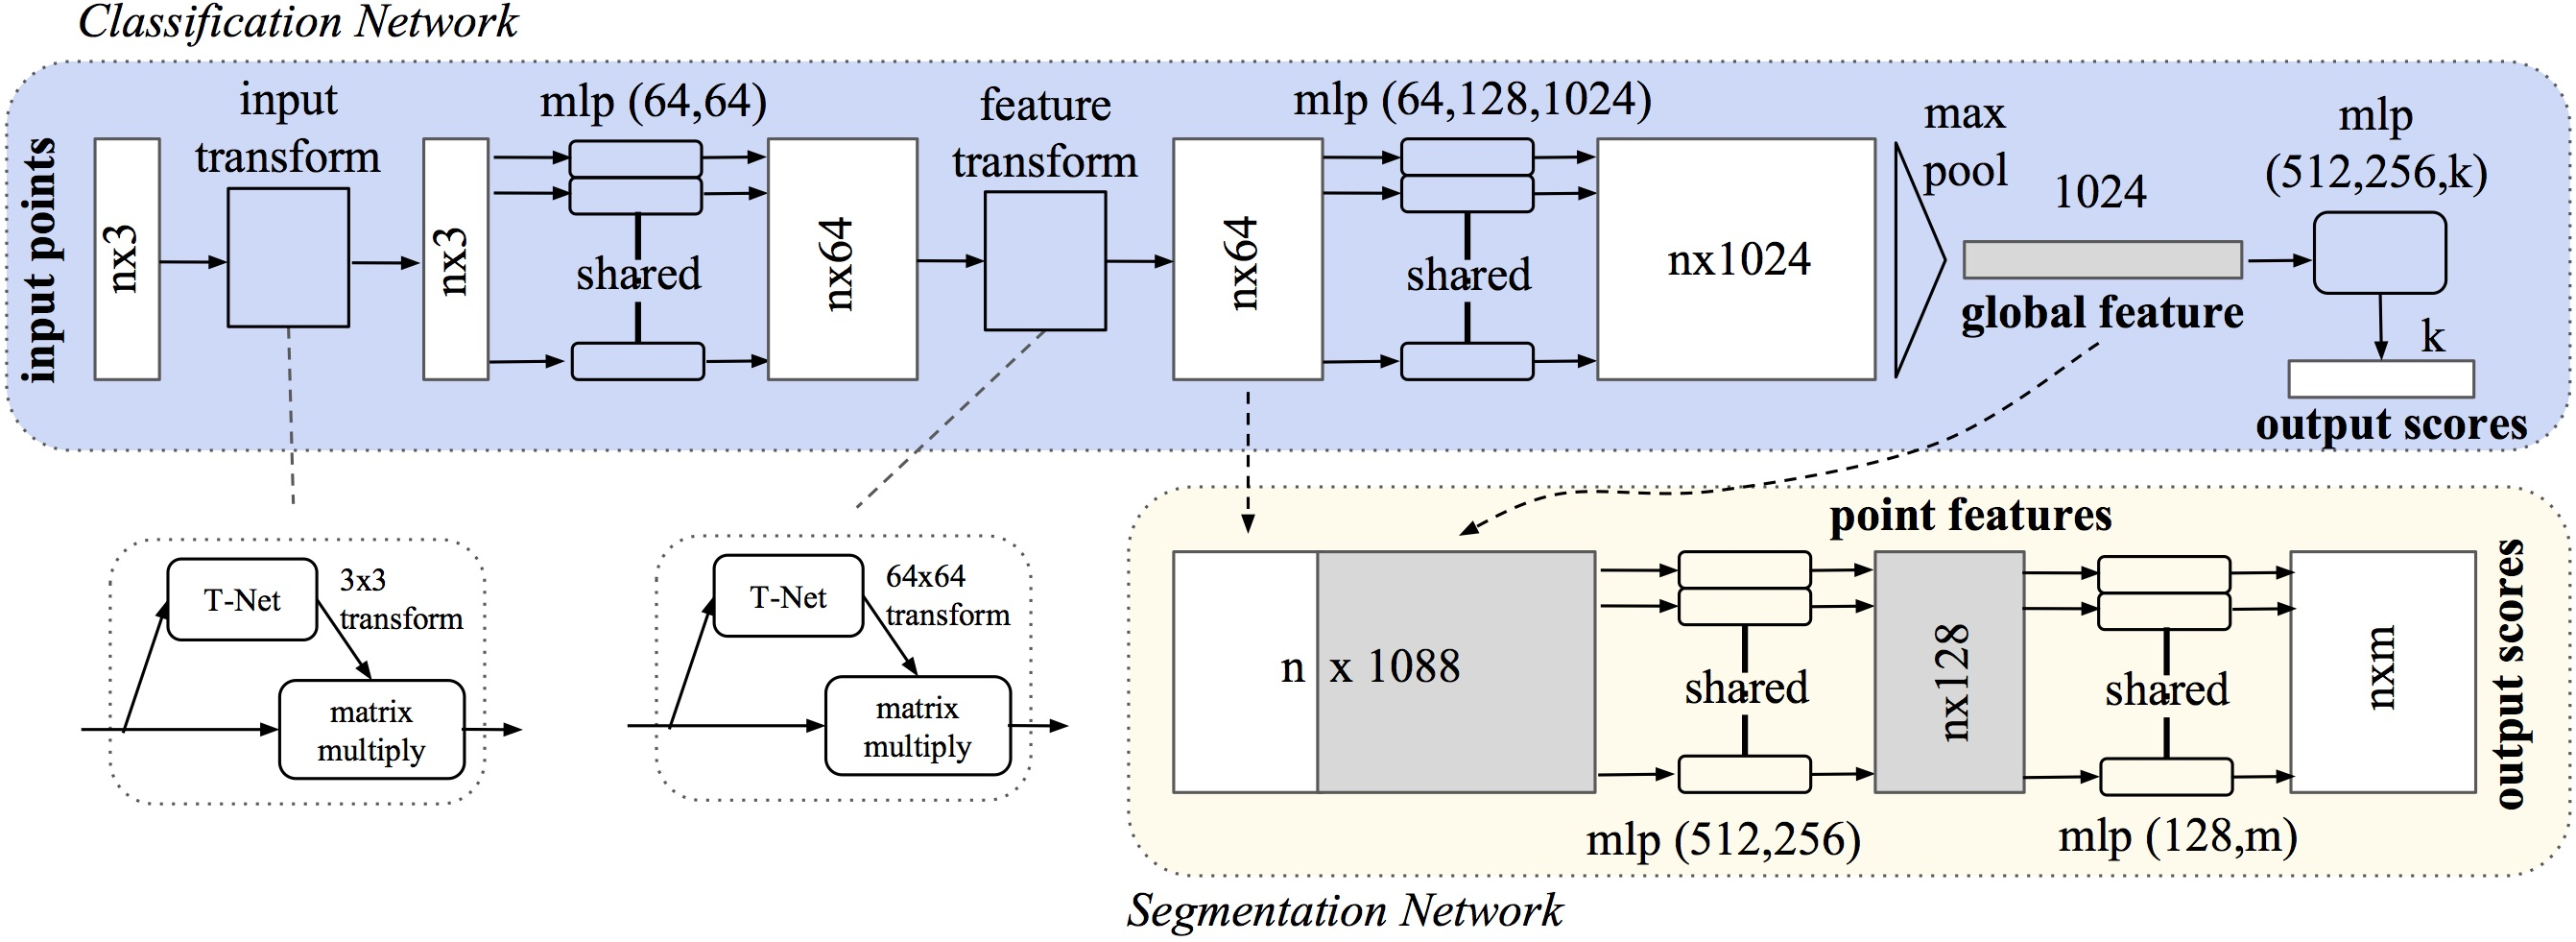

Input Transformation (Input T-Net):

Apply Conv1D and Dense layers to output a transformation matrix (3x3).
Use Lambda to multiply the original input by this matrix.


In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, MaxPooling1D, Flatten, Reshape, Lambda
import tensorflow as tf


In [ ]:

#Pointnet
def pointnet_network(input_points, num_classes):
    
    #input layer 
    points = Input(points=input_points)
    
    t_net_1 = conv_t_net(points, 3)
    #1.lambda to wrap Tensoorflow as keras layer
    #2.Args 0 = points , 1 = transormation matrix
    #3. ([points , t_net_1]) , the tensors being passed to the lambda layer 
    x = Lambda(lambda args: tf.matmul(args[0], args[1]))([points , t_net_1])

Feature Extraction:

Apply Conv1D with 64, 128, and 1024 filters.
Use BatchNormalization after each Conv1D layer.
Pool over all points using MaxPooling1D.

In [ ]:
    #feature extraction 
    #first mlp
    x = Conv1D(64,1, activation='relu')(x)
    x = BatchNormalization()(x)


    #second mlp
    x = Conv1D(128,1, activation='relu')(x)
    x = BatchNormalization()(x)

    #third mlp
    x = Conv1D(1024,1, activation='relu')(x)
    x = BatchNormalization()(x)
    #global pooling 
    x = MaxPooling1D(pool_size=points[0])(x)
    global_features = Flatten()(x) #features to vector

Feature Transformation (Feature T-Net):

Use dense_t_net to create a transformation matrix.
Apply it to the features with Lambda.

In [ ]:

    t_net_2 = dense_t_net(global_features,64)
    x = Lambda(lambda args: tf.matmul(args[0], args[1]))([x , t_net_2])

High-Level Feature Extraction:

Apply Conv1D layers again with filters 64, 128, 1024.
MaxPooling is used to aggregate the features globally.

In [ ]:
    #Transformed features 
    x = Conv1D(64, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(1024, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=1)(x)
    x = Flatten()(x)

Fully Connected Layers:

Use Dense and Dropout layers to classify the 

In [ ]:
    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def conv_t_net(inputs, output_size):
        # Convolutional layers
    x = Conv1D(64, 1, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(128, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(1024, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=inputs.shape[1])(x)  # Pool over all points
    x = Flatten()(x)
    
    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    
    # Output transformation matrix
    x = Dense(output_size * output_size, activation='linear',
              kernel_initializer='zeros', bias_initializer=tf.keras.initializers.Identity())(x)
    transformation = Reshape((output_size, output_size))(x)
    
    return transformation

In [ ]:
def dense_t_net(global_features, output_size):
    # Fully connected layers for feature transformation
    x = Dense(512, activation='relu')(global_features)
    x = Dense(256, activation='relu')(x)
    
    # Output transformation matrix
    x = Dense(output_size * output_size, activation='linear',
              kernel_initializer='zeros', bias_initializer=tf.keras.initializers.Identity())(x)
    transformation = Reshape((output_size, output_size))(x)
    
    return transformation